In [24]:
#importing libraries
import numpy as np
import pandas as pd
from stl import mesh
from pathlib import Path
from mpl_toolkits import mplot3d
from matplotlib import pyplot
from alphashape import alphashape

#input necessary information
filename = 'Body3.stl'
sliceheight = 10 #in mm
feedrate = 1000 #in mm/min

xOffset = 2
yOffset = 2

#create path
path = Path(f'Input/{filename}')
#path = Path(f'/Users/ben/Desktop/Projects/VScode-Python/HS/Body1 copy.stl')


#as a precaution, check that the file exists
if not path.exists():
    raise ValueError(f"Cannot find path={str(path)}")

#creating a mesh from the stl file
body = mesh.Mesh.from_file(path)

vertices = body.points[:, :3] #create array from mesh
vertices_df = pd.DataFrame(vertices, columns = ['X','Y','height']) #create dataframe from array
#pd.set_option('display.max_rows', None) #display options, used for debugging
#vertices_df = vertices_df[vertices_df.height == sliceheight] #reject all values that are not at slice height
#vertices_df['X'] = vertices_df['X'] * -1 #flip in along the x axis
vertices_df = vertices_df.drop_duplicates() #drop duplicates
vertices_df = vertices_df.reset_index(drop=True) #reset the index
vertices_df = pd.concat([vertices_df, vertices_df.loc[[0]]], ignore_index=True) #make sure loop is closed

#make so that no values is less than 2
vertices_df['X'] = vertices_df['X'] - min(vertices_df['X']) + xOffset
vertices_df['Y'] = vertices_df['Y'] - min(vertices_df['Y']) + yOffset

In [30]:
points = np.array([(row['X'], row['Y']) for _, row in vertices_df.iterrows()])

# Set the alpha parameter (controls the shape flexibility)
alpha = 0.1

# Compute the alpha shape
alpha_shape = alphashape(points, alpha)

# Extract the perimeter path vertices
perimeter_path_vertices = np.array(alpha_shape.exterior.coords)

# Convert the vertices to a DataFrame
perimeter_path_df = pd.DataFrame(perimeter_path_vertices, columns=['X', 'Y'])

perimeter_path_df = perimeter_path_df.round(4)

print(perimeter_path_df)

         X       Y
0   2.2626  4.9730
1   2.5120  5.5079
2   2.8354  6.0549
3   3.2276  6.6053
4   3.6834  7.1511
..     ...     ...
92  2.0834  3.1317
93  2.0000  3.5302
94  2.0033  3.9754
95  2.0917  4.4592
96  2.2626  4.9730

[97 rows x 2 columns]


/var/folders/4g/x9cy574s2fl_khtrkwvt7xw80000gn/T/ipykernel_8882/3976564215.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(figure)


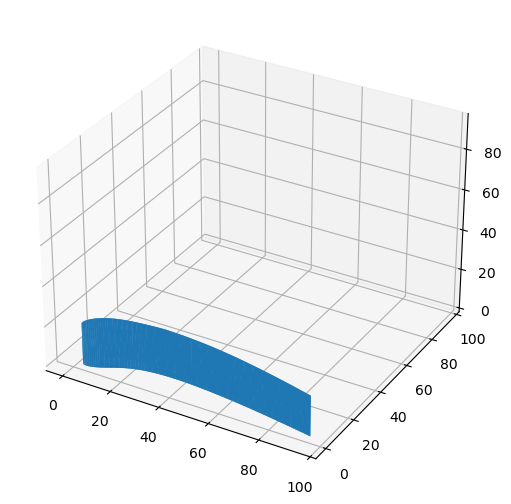

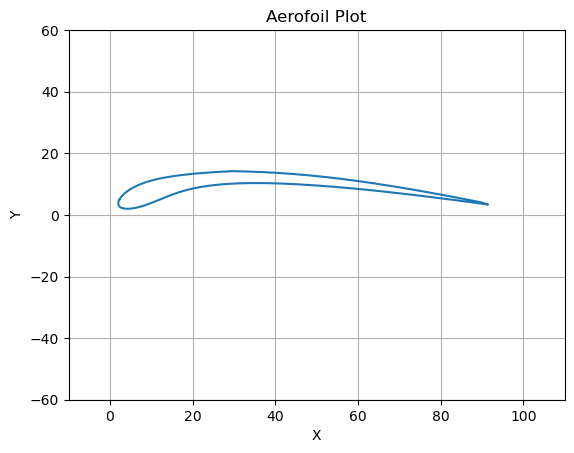

In [31]:
#visualise
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(body.vectors))
scale = body.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)
fig, ax = pyplot.subplots()
ax.plot(perimeter_path_df['X'], perimeter_path_df['Y'])
ax.set_title('Aerofoil Plot')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_ylim(-60, 60)
ax.set_xlim(-10, 110)
pyplot.grid()
pyplot.show()

In [32]:
#compiling the gCode


with open('Output/ToolPath.gcode', 'w') as file: #create file and set mode to write
    file.write(";gCode for cutting an aerofoil")
    file.write('\n')
    file.write('G90')
    file.write('\n')
    file.write('G21')
    
    for index in range(len(perimeter_path_df)):
        file.write('\n')
        file.write(f'G1 X{perimeter_path_df.X[index]} Y{perimeter_path_df.Y[index]} F{feedrate}')
    
    file.write('\n')
    file.write('G1 X0 Y0')